In [1]:
#!/usr/bin/env python3
############## ROS Import ###############
import rospy
import std_msgs
from sensor_msgs.msg import Image
import ros_numpy

import numpy as np
import random
import time
import itertools
import os
import cv2
from cv_bridge import CvBridge, CvBridgeError
%matplotlib notebook
from matplotlib import pyplot as plt
from IPython.display import display, HTML, clear_output
from IPython.display import Image as IPython_Image

import tensorflow as tf

In [2]:
path_raw_video = '/home/kimbring2/Desktop/raw_video.avi'
path_seg_video = '/home/kimbring2/Desktop/seg_video.avi'
path_gan_video = '/home/kimbring2/Desktop/gan_video.avi'
fps = 5
size = (512,512)

raw_video_out = cv2.VideoWriter(path_raw_video, cv2.VideoWriter_fourcc(*'DIVX'), fps, (640,360))
seg_video_out = cv2.VideoWriter(path_seg_video, cv2.VideoWriter_fourcc(*'DIVX'), fps, (640,360))
gan_video_out = cv2.VideoWriter(path_gan_video, cv2.VideoWriter_fourcc(*'DIVX'), fps, (256,256))

imported_rl = tf.saved_model.load("/home/kimbring2/Desktop/rl_model")
imported_seg = tf.saved_model.load("/home/kimbring2/Desktop/seg_model")
imported_gan = tf.saved_model.load("/home/kimbring2/Desktop/gan_model")

f_rl = imported_rl.signatures["serving_default"]
f_seg = imported_seg.signatures["serving_default"]
f_gan = imported_gan.signatures["serving_default"]

rl_test_input = np.zeros([1,128,128,5])
seg_test_input = np.zeros([1,256,256,3])
gan_test_input = np.zeros([1,256,256,3])

rl_test_tensor = tf.convert_to_tensor(rl_test_input, dtype=tf.float32)
seg_test_tensor = tf.convert_to_tensor(seg_test_input, dtype=tf.float32)
gan_test_tensor = tf.convert_to_tensor(gan_test_input, dtype=tf.float32)

memory_state = tf.zeros([1,128], dtype=np.float32)
carry_state = tf.zeros([1,128], dtype=np.float32)

f_rl = imported_rl.signatures["serving_default"]
rl_test_input = np.zeros([1,128,128,5])

print(f_rl(input_1=rl_test_tensor, input_2=memory_state, input_3=carry_state)['core_lstm'].numpy()[0])
print(f_rl(input_1=rl_test_tensor, input_2=memory_state, input_3=carry_state)['core_lstm_1'].numpy()[0])
print(f_rl(input_1=rl_test_tensor, input_2=memory_state, input_3=carry_state)['dense_1'].numpy()[0])

time.sleep(1)
print(f_seg(seg_test_tensor)['conv2d_transpose_4'].numpy()[0])

time.sleep(1)
print(f_gan(gan_test_tensor)['conv2d_transpose_7'].numpy()[0])

bridge = CvBridge()

raw_video_frame = np.zeros([640,360,3])
seg_video_frame = np.zeros([640,360,3])
gan_video_frame = np.zeros([256,256,3])
camera_frame = np.zeros([128,128,3])

step = 0

[ 0.02713874  0.06005813  0.04078095 -0.03052991  0.02637849 -0.00611609
 -0.00944612 -0.07367764 -0.01422878  0.04867332  0.02397522  0.00358911
 -0.02968127 -0.06942587 -0.06308478  0.02261708 -0.03013289  0.01531628
  0.01681145 -0.00154622 -0.02879509 -0.02069551 -0.01990019 -0.01958903
 -0.00712633 -0.08289555 -0.0232588   0.00328758 -0.04316648  0.0664915
 -0.01951028  0.07592839  0.00106595 -0.13857298 -0.02930625 -0.00572233
  0.00882681  0.00717156  0.04781251 -0.0166747  -0.02227762 -0.00338558
 -0.00942232 -0.05090337  0.01776635  0.01234411  0.01386332  0.05975145
  0.0044229  -0.00880699  0.00034793 -0.00107876  0.01677111 -0.02492902
 -0.01436925 -0.04805308  0.03073946 -0.06767916  0.02970532  0.0123794
  0.04244807 -0.04241659 -0.02496633 -0.03387221  0.01268228 -0.03583913
 -0.02503021 -0.01895396 -0.05216826 -0.0082771  -0.03433919  0.02682105
 -0.01969396 -0.00496937 -0.01968884 -0.01732663 -0.0369112   0.01713539
  0.0062648   0.07168779  0.00843865  0.08332725  0.0

In [3]:
def arrayShow(imageArray):
    image = bytes(cv2.imencode('.jpg', imageArray)[1])
    return IPython_Image(data=image)
    
    
def image_callback(msg):
    global camera_frame
    global raw_video_frame
    global seg_video_frame
    global gan_video_frame
    global step
    
    cv_image = bridge.imgmsg_to_cv2(msg, "passthrough")
    cv_image = cv2.resize(cv_image, (640, 360), interpolation=cv2.INTER_AREA)
    
    frame = cv_image
    raw_video_frame = cv_image
    #raw_video_out.write(cv_image)
    
    cv_image_shape = cv_image.shape
    width = cv_image_shape[1]
    height = cv_image_shape[0]
    
    cv_image = cv2.resize(cv_image, (256, 256), interpolation=cv2.INTER_AREA)
    cv_image = cv2.normalize(cv_image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
    #cv_image = cv2.cvtColor(cv_image, cv2.COLOR_RGB2RGBA).astype(np.float32)
    
    resized = np.array([cv_image])
    input_tensor = tf.convert_to_tensor(resized, dtype=tf.float32)
    #output = f_cyclegan(input_tensor)['conv2d_transpose_7'].numpy()[0]
    
    pred_mask = f_seg(input_tensor)['conv2d_transpose_4']
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = pred_mask[0]
    pred_mask = tf.keras.preprocessing.image.array_to_img(pred_mask)
    pred_mask = np.array(pred_mask)
    ret, thresh = cv2.threshold(pred_mask, 126, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    erudition_image = cv2.erode(thresh, kernel, iterations=2)  #// make dilation image
    dilation_image = cv2.dilate(erudition_image, kernel, iterations=2)  #// make dilation image
    dilation_image = cv2.resize(np.float32(dilation_image), dsize=(640,360), interpolation=cv2.INTER_AREA)
    dilation_image = dilation_image != 255.0

    # converting from BGR to HSV color space
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Red color
    low_red = np.array([120, 155, 84])
    high_red = np.array([179, 255, 255])
    red_mask = cv2.inRange(hsv_frame, low_red, high_red)
    red = cv2.bitwise_and(frame, frame, mask=red_mask)

    # Blue color
    low_blue = np.array([110, 130, 2])
    high_blue = np.array([126, 255, 255])
    blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
    kernel = np.ones((10, 10), np.uint8)
    blue_mask = cv2.dilate(blue_mask, kernel, iterations=1)  #// make dilation image
    blue = cv2.bitwise_and(frame, frame, mask=blue_mask)

    # Green color
    low_green = np.array([25, 52, 72])
    high_green = np.array([60, 255, 255])
    green_mask = cv2.inRange(hsv_frame, low_green, high_green)
    kernel = np.ones((5, 5), np.uint8)
    green_mask = cv2.dilate(green_mask, kernel, iterations=1)  #// make dilation image
    green = cv2.bitwise_and(frame, frame, mask=green_mask)

    mask = green_mask + blue_mask + dilation_image

    result = cv2.bitwise_and(frame, frame, mask=mask)
    result_mean = np.mean(result)

    indy, indx, indz = np.where((result==0))
    result[indy, indx, indz] = result_mean
    
    #cv2.imwrite("/home/kimbring2/Desktop/output_seg" + "_" + str(step)+ "_.jpg", result)
    #seg_video_out.write(np.uint8(result))
    seg_video_frame = result
    
    test_image = result
    test_image = (test_image / 127.5) - 1

    test_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
    test_tensor = tf.image.resize(test_tensor, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    test_tensor = tf.reshape(test_tensor, [1,256,256,3], name=None)

    prediction = f_gan(test_tensor)['conv2d_transpose_7'].numpy()
    
    gan_result = prediction[0]* 0.5 + 0.5
    #cv2.imwrite("/home/kimbring2/Desktop/output_gan" + "_" + str(step)+ "_.jpg", gan_result * 255.0)
    #gan_video_out.write(np.uint8(gan_result * 255.0))
    #gan_result = gan_result * 255
    gan_video_frame = np.uint8(gan_result * 255.0)
    
    camera_frame = cv2.resize(gan_result, (128, 128), interpolation=cv2.INTER_AREA)
    step += 1
    

lidar_value = 0
def lidar_callback(msg):
    global lidar_value
    
    lidar_value = msg.data
    #print("lidar: " + str(msg))

    
infrared_value = 'False'
def infrared_callback(msg):
    global infrared_value
    
    infrared_value = msg.data
    #print("infrared: " + str(msg))
    
    
############## ROS Part ###############
rospy.init_node('deepsoccer')
wheel1 = rospy.Publisher('/deepsoccer_motors/cmd_str_wheel1', std_msgs.msg.String, queue_size=1)
wheel2 = rospy.Publisher('/deepsoccer_motors/cmd_str_wheel2', std_msgs.msg.String, queue_size=1)
wheel3 = rospy.Publisher('/deepsoccer_motors/cmd_str_wheel3', std_msgs.msg.String, queue_size=1)
wheel4 = rospy.Publisher('/deepsoccer_motors/cmd_str_wheel4', std_msgs.msg.String, queue_size=1)
solenoid = rospy.Publisher('/deepsoccer_solenoid/cmd_str', std_msgs.msg.String, queue_size=5)
roller = rospy.Publisher('/deepsoccer_roller/cmd_str', std_msgs.msg.String, queue_size=5)
rospy.Subscriber("/deepsoccer_camera/raw", Image, image_callback)
rospy.Subscriber("/deepsoccer_lidar", std_msgs.msg.String, lidar_callback)
rospy.Subscriber("/deepsoccer_infrared", std_msgs.msg.String, infrared_callback)
 
rate = rospy.Rate(5000)

stop_action = [0, 0, 0, 0, 'stop', 'none']
forward_action = [50, 1074, 1074, 50, 'in', 'none']
left_action = [1074, 1074, 1074, 1074, 'in', 'none']
right_action = [50, 50, 50, 50, 'in', 'out']
bacward_action = [1074, 50, 50, 1074, 'in', 'none']
hold_action = [0, 0, 0, 0, 'in', 'none']
kick_action = [0, 0, 0, 0, 'stop', 'out']
run_action = [100, 1124, 1124, 100, 'stop', 'none']
robot_action_list = [stop_action, forward_action, left_action, right_action, bacward_action, hold_action, kick_action, run_action]

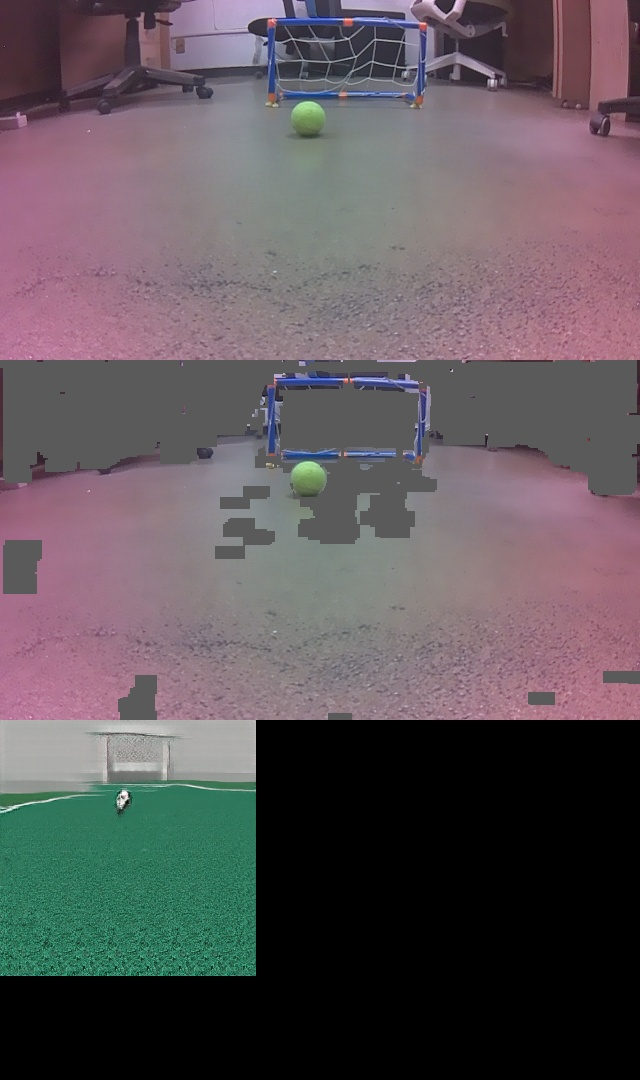

In [ ]:
%matplotlib notebook

############## ROS + Deep Learning Part ###############
memory_state = np.zeros([1,128], dtype=np.float32)
carry_state = np.zeros([1,128], dtype=np.float32)
while not rospy.is_shutdown():
    #print("start")
    
    action_index = 0
    #print("lidar_value: " + str(lidar_value))
    lidar_ = int(lidar_value) / 1200
    #print("lidar_: " + str(lidar_))
    
    #print("infrared_value: " + str(infrared_value))
    infrared_ = int(infrared_value == 'True')
    #print("infrared_: " + str(infrared_))
    #print("action: " + str(action))
    #print("")

    clear_output(wait=True)
    #print("camera_frame.shape: ", camera_frame.shape)
    imgs_array = np.zeros((360*3,640,3))
    imgs_array[0:360,:,:] = raw_video_frame
    imgs_array[360:720,:,:] = seg_video_frame
    imgs_array[720:720+256,0:256,:] = gan_video_frame
    
    img = arrayShow(imgs_array)
    display(img)
    
    frame_state_channel = camera_frame
    lidar_state_channel = (np.ones(shape=(128,128,1), dtype=np.float32)) * lidar_
    infrared_state_channel = (np.ones(shape=(128,128,1), dtype=np.float32)) * infrared_ / 2.0
    state_channel1 = np.concatenate((frame_state_channel, lidar_state_channel), axis=2)
    state_channel2 = np.concatenate((state_channel1, infrared_state_channel), axis=2)
    state_channel2 = np.array([state_channel2])
    #print("state_channel2.shape: " + str(state_channel2.shape))
    
    state_channel_tensor = tf.convert_to_tensor(state_channel2, dtype=tf.float32)
    memory_state = tf.convert_to_tensor(memory_state, dtype=tf.float32)
    carry_state = tf.convert_to_tensor(carry_state, dtype=tf.float32)
    #prediction = f_rl(input_1=state_channel_tensor, input_2=memory_state, input_3=carry_state)
    #action_logit = prediction['dense_1'].numpy()[0]
    #memory_state = prediction['core_lstm'].numpy()
    #carry_state = prediction['core_lstm_1'].numpy()
    #predict_value = f_rl(state_channel_tensor)['dueling_model'].numpy()[0].numpy()[0]
    #print("action_logit: " + str(action_logit))
    #print("memory_state.shape: " + str(memory_state.shape))
    #print("carry_state.shape: " + str(carry_state.shape))
    #action_index = np.argmax(action_logit, axis=0) 
    #print("action_index: " + str(action_index))
    action_index = 0
    #print("")
    action = robot_action_list[action_index]
    
    wheel1_action = action[0]
    wheel2_action = action[1]
    wheel3_action = action[2]
    wheel4_action = action[3]
    roller_action = action[4]
    solenoid_action = action[5]
    
    wheel1.publish(str(wheel1_action))
    wheel2.publish(str(wheel2_action))
    wheel3.publish(str(wheel3_action))
    wheel4.publish(str(wheel4_action))
    roller.publish(roller_action)
    solenoid.publish(solenoid_action)
    
    #time.sleep(0.1)
 
rate.sleep()